read_data: dropping 36 rows with non-numeric intensity values

===== RETARDANCE RESULTS =====



ValueError: `ydata` must not be empty!

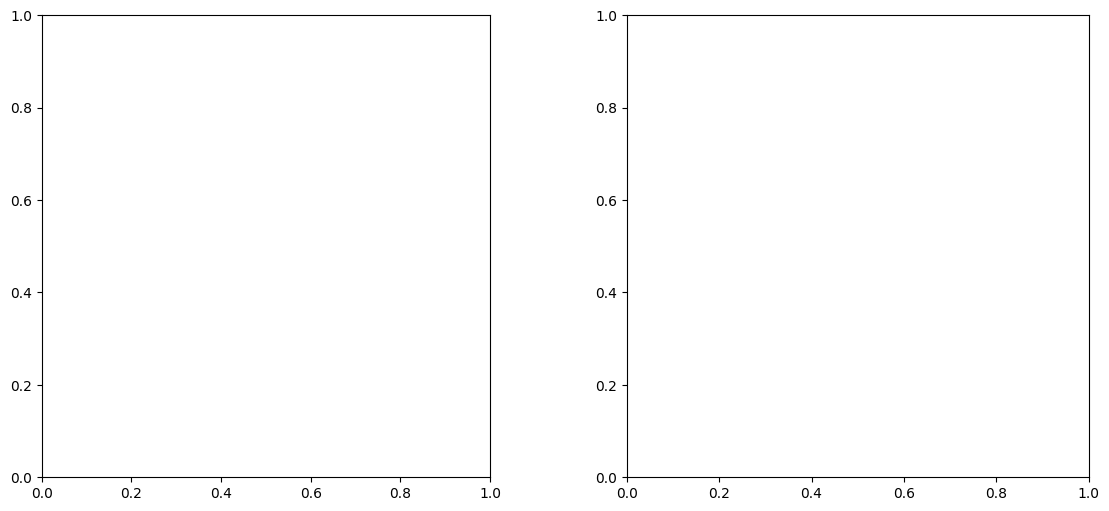

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib import patches

def read_data(path):
    df = pd.read_csv(path, comment=None)
    df.columns = [c.strip() for c in df.columns]

    # if the first column name starts with '#', strip
    first_col = df.columns[0]
    if first_col.startswith('#'):
        new_first = first_col.lstrip('#').strip()
        df = df.rename(columns={first_col: new_first})
        df.columns = [c.strip() for c in df.columns]  # re-normalize

    # ensure first column is numeric angles
    df.iloc[:, 0] = pd.to_numeric(df.iloc[:, 0], errors='coerce')

    # drop bad angle rows
    if df.iloc[:, 0].isna().any():
        n_bad = df.iloc[:, 0].isna().sum()
        print(f"read_data: dropping {n_bad} rows with non-numeric angles")
        df = df.dropna(subset=[df.columns[0]]).reset_index(drop=True)

    # determine y cols
    y_cols = [c for c in df.columns if c.startswith("y_")]
    if not y_cols:
        y_cols = list(df.columns[1:])

    # coerce intensity columns to numeric (non-numeric -> NaN)
    df[y_cols] = df[y_cols].apply(pd.to_numeric, errors='coerce')

    # drop rows with nan in intensities or fill them
    if df[y_cols].isna().any().any():
        n_bad_rows = df[y_cols].isna().any(axis=1).sum()
        print(f"read_data: dropping {n_bad_rows} rows with non-numeric intensity values")
        df = df.loc[~df[y_cols].isna().any(axis=1)].reset_index(drop=True)

    angles = df.iloc[:, 0].values      # degrees
    intensities = df[y_cols].values    # shape (n_angles, n_ycols)

    return angles, intensities, y_cols, df


file_path = "/Users/lucas/Desktop/physics/Year 3/Dissert 1/dat/sugar2/red-633/300gL.csv" 
angles, intensities, y_cols, df = read_data(file_path)

df_norm = df.copy()
df_norm[y_cols] = df[y_cols] / df[y_cols].max()

def model_f(theta, p1, p2, p3):
    theta_rad = np.deg2rad(theta)
    return (p1 * np.cos(theta_rad - p3))**2 + (p2 * np.sin(theta_rad - p3))**2

retardances = []
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.2])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax2.set_aspect("equal", "box")

colors = plt.cm.tab20(np.linspace(0, 1, len(y_cols)))

print("\n===== RETARDANCE RESULTS =====\n")

for i, col in enumerate(y_cols):
    y = df_norm[col].values
    color = colors[i]

    try:
        popt, _ = curve_fit(model_f, angles, y, bounds=([0, 0, 0], [2, 2, np.pi]))
        Emax, Emin, alpha = popt
    except RuntimeError as e:
        print(f"Fit failed for {col} {e}")
        continue

    Imax = Emax**2
    Imin = Emin**2

    m = (Imax - Imin) / (Imax + Imin)
    m = np.clip(m, 0, 1)

    Gamma = 2 * np.arcsin(np.sqrt(m))
    Gamma_deg = np.degrees(Gamma)

    retardances.append(Gamma_deg)

    print(f"{col}: Retardance = {Gamma_deg:.2f} deg")

    fit_angles = np.linspace(0, 180, 200)
    ax1.plot(fit_angles, model_f(fit_angles, *popt), '-', color=color, lw=1)

    ellipse = patches.Ellipse(
        (0, 0),
        width=Emax * 2.2,
        height=Emin * 2.2,
        angle=np.degrees(alpha),
        fill=False,
        linewidth=1.5,
        alpha=0.8,
        edgecolor=color
    )
    ax2.add_patch(ellipse)

valid_retardances = [r for r in retardances if r != 0]

if valid_retardances:
    gamma = np.mean(valid_retardances)
    sigma = np.std(valid_retardances, ddof=1)
    gamma_err = sigma / np.sqrt(len(valid_retardances))

    t = 3.2e-3 # 3.2mm
    t_err = 0.5e-3 # 0.5mm
    l = 633e-9 # nm
    l_err = 1e-9 # 1 nm
    gamma_deg = gamma
    gamma_deg_err = gamma_err
    gamma = gamma * np.pi / 180 # in rad
    gamma_err = gamma_err * np.pi / 180

    bire = (0.5 / np.pi) * gamma * l / t
    bire_err = (0.5 / np.pi) * np.sqrt((l*gamma_err)**2 + (gamma*l_err)**2 + (gamma * l * t_err / t)**2) / t

    print(f"\nretardance: ({gamma_deg:.2f} +- {gamma_deg_err:.10f}), birefringence: ({bire:.8f} +- {bire_err:.8f})")
else:
    print("\nNo valid retardance values available.\n")

ax1.set_xlabel("Polariser Angle (°)")
ax1.set_ylabel("Normalised Intensity")
ax1.set_title("Normalised Intensity vs Polariser Angle (All Orientations)")
ax1.grid(True, linestyle="--", alpha=0.5)
ax2.set_xlim([-1.3, 1.3])
ax2.set_ylim([-1.3, 1.3])
ax2.set_title("Polarisation Ellipses (All Fits)", fontsize=11)
ax2.axis("off")
plt.tight_layout()
plt.show()

print("\n================================\n")